In [1]:
from keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )
import numpy as np
print( f"NumPy {np.__version__}\n" )
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report

from gradcam import get_img_array,make_gradcam_heatmap,save_and_display_gradcam
from show_predicted_img import show_predicted_img

TensorFlow 2.13.0
tf.keras.backend.image_data_format() = channels_last
NumPy 1.23.2



In [2]:
# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [3]:
# Set fixed seeding values for reproducability during experiments
# Skip this cell if random initialization (with varied results) is needed
# np.random.seed(1234)
# tf.random.set_seed(5678)

In [4]:
PATH = 'dataset/train/'

In [5]:
train_ds = image_dataset_from_directory(
  PATH,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(224, 224))

print(train_ds.class_names)

Found 640 files belonging to 4 classes.
Using 576 files for training.


2023-11-11 15:48:45.447305: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-11 15:48:45.447333: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-11-11 15:48:45.447345: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-11-11 15:48:45.447417: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-11 15:48:45.447467: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


['caribou', 'deer', 'elk', 'moose']


In [6]:
val_ds = image_dataset_from_directory(
  PATH,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(224, 224))

print(train_ds.class_names)

Found 640 files belonging to 4 classes.
Using 64 files for validation.
['caribou', 'deer', 'elk', 'moose']


In [7]:
test_ds = image_dataset_from_directory(
  'dataset/test/',
  image_size=(224, 224))

print(test_ds.class_names)

Found 160 files belonging to 4 classes.
['caribou', 'deer', 'elk', 'moose']


In [8]:
dataaug = tf.keras.models.Sequential( [
                                          tf.keras.Input(shape=(224,224,3)),
                                          tf.keras.layers.RandomFlip(mode='horizontal', name='rand_flip'),
                                          tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest', name='rand_trans'),
                                          tf.keras.layers.RandomRotation(factor=0.1, fill_mode='nearest', name='rand_rot'),
                                          tf.keras.layers.RandomZoom(height_factor=0.1,fill_mode='nearest'),
                                          tf.keras.layers.RandomBrightness(0.2),
                                          tf.keras.layers.Rescaling(1./255)
                                      ],
                                     name='dataaug' )

In [9]:
c = 0
for x,y in train_ds:
    # print(x.shape)
    # print(x)
    # print(y)
    c += len(x)
print(c)

576


In [10]:
augmented_train = train_ds.map(lambda x,y: (dataaug(x,training=True),y))

2023-11-11 15:48:49.537424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


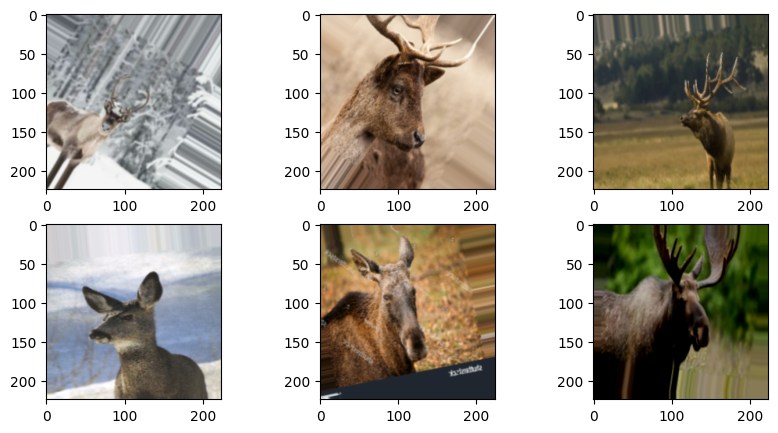

In [11]:
# show original vs resized
fig, ax = plt.subplots(2, 3, figsize=(10,5))
ax = ax.ravel()
for images, labels in augmented_train:
    for i in range(6):
        ax[i].imshow(images[i])

In [12]:
full_train_ds = train_ds.concatenate(augmented_train)

In [13]:
c = 0
for x,y in full_train_ds:
    c += len(x)
print(c)

2023-11-11 15:48:58.905128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1152


In [14]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = full_train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.prefetch(buffer_size=AUTOTUNE)

In [15]:
def preprocess(images, labels):
  return preprocess_input(images), labels

train_dataset = train_dataset.map(preprocess)
validation_dataset = validation_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

In [16]:
base_model = ResNet152V2(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet"
                         )
base_model.trainable = False
# for layer in base_model.layers:
#     # if layer.name in ['conv5_block3_3_conv']:
#     #     layer.trainable = True
    # if "BatchNormalization" in layer.__class__.__name__:
    #     layer.trainable = True

In [17]:
# Fine-tune from this layer onwards
start_tune = 528
stop_tune = 561


for layer in base_model.layers[start_tune:stop_tune]:
  layer.trainable = True

# for layer in base_model.layers:
#   if layer.__class__.__name__ in ["BatchNormalization"]:
#     layer.trainable = True

In [18]:
for i,layer in enumerate(base_model.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_2 , trainable = False
Layer 1: name = conv1_pad , trainable = False
Layer 2: name = conv1_conv , trainable = False
Layer 3: name = pool1_pad , trainable = False
Layer 4: name = pool1_pool , trainable = False
Layer 5: name = conv2_block1_preact_bn , trainable = False
Layer 6: name = conv2_block1_preact_relu , trainable = False
Layer 7: name = conv2_block1_1_conv , trainable = False
Layer 8: name = conv2_block1_1_bn , trainable = False
Layer 9: name = conv2_block1_1_relu , trainable = False
Layer 10: name = conv2_block1_2_pad , trainable = False
Layer 11: name = conv2_block1_2_conv , trainable = False
Layer 12: name = conv2_block1_2_bn , trainable = False
Layer 13: name = conv2_block1_2_relu , trainable = False
Layer 14: name = conv2_block1_0_conv , trainable = False
Layer 15: name = conv2_block1_3_conv , trainable = False
Layer 16: name = conv2_block1_out , trainable = False
Layer 17: name = conv2_block2_preact_bn , trainable = False
Layer 18: name = conv2_block2_p

In [19]:
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                        

In [20]:
# tf.keras.utils.plot_model(base_model, to_file='resnet_feature.png', show_shapes=True, show_dtype=True, show_layer_names=False, dpi=96)

In [21]:
base_model_output = base_model.output

x = tf.keras.layers.Flatten()(base_model_output)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(4, activation="softmax")(x)

# Construct the main model
model = tf.keras.models.Model(inputs=base_model.inputs, outputs=new_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

In [22]:
for i,layer in enumerate(model.layers):
    print( f"Layer {i}: name = {layer.name} , trainable = {layer.trainable}" )

Layer 0: name = input_2 , trainable = False
Layer 1: name = conv1_pad , trainable = False
Layer 2: name = conv1_conv , trainable = False
Layer 3: name = pool1_pad , trainable = False
Layer 4: name = pool1_pool , trainable = False
Layer 5: name = conv2_block1_preact_bn , trainable = False
Layer 6: name = conv2_block1_preact_relu , trainable = False
Layer 7: name = conv2_block1_1_conv , trainable = False
Layer 8: name = conv2_block1_1_bn , trainable = False
Layer 9: name = conv2_block1_1_relu , trainable = False
Layer 10: name = conv2_block1_2_pad , trainable = False
Layer 11: name = conv2_block1_2_conv , trainable = False
Layer 12: name = conv2_block1_2_bn , trainable = False
Layer 13: name = conv2_block1_2_relu , trainable = False
Layer 14: name = conv2_block1_0_conv , trainable = False
Layer 15: name = conv2_block1_3_conv , trainable = False
Layer 16: name = conv2_block1_out , trainable = False
Layer 17: name = conv2_block2_preact_bn , trainable = False
Layer 18: name = conv2_block2_p

In [23]:
# Defining Callbacks

checkpoint_filepath = "resnet_callback/bestmodel_epoch{epoch:02d}_valloss{val_loss:.2f}.h5"
early_stop_patience = 60
reduce_lr_patience = 20
earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = early_stop_patience,
                              verbose = 1)

checkpoint    = ModelCheckpoint(checkpoint_filepath, 
                                monitor = 'val_loss', 
                                mode='min', 
                                save_best_only=True,
                                save_weights_only=False, 
                                verbose = 1,
                                option = tf.saved_model.SaveOptions)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=reduce_lr_patience, min_lr=0.00005,verbose=1)
callback_list = [earlystopping, checkpoint,reduce_lr]

In [24]:
# Model Compile 
lr = 0.0001
OPT    = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
# OPT    = tf.keras.optimizers.legacy.RMSprop(learning_rate=lr)
# OPT = tf.keras.optimizers.legacy.Adagrad(learning_rate=lr)

model.compile(loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=OPT)

In [25]:
epoch = 80
model_history=model.fit(train_dataset,
                        validation_data=validation_dataset,
                        epochs = epoch,
                        callbacks = callback_list,
                        verbose = 2)

Epoch 1/80


2023-11-11 15:49:14.984348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-11 15:49:30.876198: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-11 15:49:46.317948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.48949, saving model to resnet_callback/bestmodel_epoch01_valloss1.49.h5


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


36/36 - 41s - loss: 1.8413 - accuracy: 0.4575 - val_loss: 1.4895 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 41s/epoch - 1s/step
Epoch 2/80


2023-11-11 15:49:58.225508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 2: val_loss improved from 1.48949 to 0.86734, saving model to resnet_callback/bestmodel_epoch02_valloss0.87.h5
36/36 - 23s - loss: 1.2949 - accuracy: 0.6094 - val_loss: 0.8673 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 23s/epoch - 652ms/step
Epoch 3/80


2023-11-11 15:50:21.423343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 3: val_loss improved from 0.86734 to 0.79311, saving model to resnet_callback/bestmodel_epoch03_valloss0.79.h5
36/36 - 23s - loss: 1.1983 - accuracy: 0.6319 - val_loss: 0.7931 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 23s/epoch - 650ms/step
Epoch 4/80


2023-11-11 15:50:44.852993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 4: val_loss improved from 0.79311 to 0.57049, saving model to resnet_callback/bestmodel_epoch04_valloss0.57.h5
36/36 - 24s - loss: 0.9824 - accuracy: 0.6641 - val_loss: 0.5705 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 24s/epoch - 655ms/step
Epoch 5/80


2023-11-11 15:51:08.610151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 5: val_loss improved from 0.57049 to 0.48152, saving model to resnet_callback/bestmodel_epoch05_valloss0.48.h5
36/36 - 24s - loss: 0.9105 - accuracy: 0.6597 - val_loss: 0.4815 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 24s/epoch - 676ms/step
Epoch 6/80


2023-11-11 15:51:32.984702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 6: val_loss did not improve from 0.48152
36/36 - 22s - loss: 0.8995 - accuracy: 0.6667 - val_loss: 0.6220 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 22s/epoch - 612ms/step
Epoch 7/80


2023-11-11 15:51:54.332163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 7: val_loss did not improve from 0.48152
36/36 - 21s - loss: 0.9214 - accuracy: 0.6762 - val_loss: 0.5725 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 21s/epoch - 583ms/step
Epoch 8/80


2023-11-11 15:52:15.326550: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 8: val_loss did not improve from 0.48152
36/36 - 21s - loss: 0.9355 - accuracy: 0.6727 - val_loss: 0.5438 - val_accuracy: 0.8438 - lr: 1.0000e-04 - 21s/epoch - 594ms/step
Epoch 9/80


2023-11-11 15:52:36.600302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 9: val_loss did not improve from 0.48152
36/36 - 21s - loss: 0.8815 - accuracy: 0.6580 - val_loss: 0.5102 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 21s/epoch - 576ms/step
Epoch 10/80


2023-11-11 15:52:57.348094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 10: val_loss did not improve from 0.48152
36/36 - 21s - loss: 0.8481 - accuracy: 0.6797 - val_loss: 0.5219 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 21s/epoch - 588ms/step
Epoch 11/80


2023-11-11 15:53:18.546557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 11: val_loss did not improve from 0.48152
36/36 - 21s - loss: 0.8137 - accuracy: 0.6858 - val_loss: 0.5893 - val_accuracy: 0.8438 - lr: 1.0000e-04 - 21s/epoch - 577ms/step
Epoch 12/80


2023-11-11 15:53:39.333319: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 12: val_loss did not improve from 0.48152
36/36 - 21s - loss: 0.8503 - accuracy: 0.6858 - val_loss: 0.5632 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 21s/epoch - 577ms/step
Epoch 13/80


2023-11-11 15:54:00.151252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 13: val_loss improved from 0.48152 to 0.47703, saving model to resnet_callback/bestmodel_epoch13_valloss0.48.h5
36/36 - 23s - loss: 0.8272 - accuracy: 0.6840 - val_loss: 0.4770 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 23s/epoch - 629ms/step
Epoch 14/80


2023-11-11 15:54:23.519446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 14: val_loss improved from 0.47703 to 0.45386, saving model to resnet_callback/bestmodel_epoch14_valloss0.45.h5
36/36 - 23s - loss: 0.7613 - accuracy: 0.6962 - val_loss: 0.4539 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 23s/epoch - 651ms/step
Epoch 15/80


2023-11-11 15:54:46.965223: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 15: val_loss did not improve from 0.45386
36/36 - 22s - loss: 0.7576 - accuracy: 0.6988 - val_loss: 0.4680 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 22s/epoch - 598ms/step
Epoch 16/80


2023-11-11 15:55:07.777064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 16: val_loss did not improve from 0.45386
36/36 - 21s - loss: 0.7845 - accuracy: 0.6910 - val_loss: 0.5422 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 21s/epoch - 578ms/step
Epoch 17/80


2023-11-11 15:55:28.615687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 17: val_loss did not improve from 0.45386
36/36 - 21s - loss: 0.7438 - accuracy: 0.7057 - val_loss: 0.5041 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 21s/epoch - 577ms/step
Epoch 18/80


2023-11-11 15:55:49.437871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 18: val_loss did not improve from 0.45386
36/36 - 21s - loss: 0.7583 - accuracy: 0.6901 - val_loss: 0.5427 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 21s/epoch - 576ms/step
Epoch 19/80


2023-11-11 15:56:10.188273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 19: val_loss did not improve from 0.45386
36/36 - 21s - loss: 0.7441 - accuracy: 0.6997 - val_loss: 0.4540 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 21s/epoch - 577ms/step
Epoch 20/80


2023-11-11 15:56:30.957625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 20: val_loss improved from 0.45386 to 0.38065, saving model to resnet_callback/bestmodel_epoch20_valloss0.38.h5
36/36 - 23s - loss: 0.7410 - accuracy: 0.7101 - val_loss: 0.3807 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 23s/epoch - 637ms/step
Epoch 21/80


2023-11-11 15:56:54.664028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 21: val_loss improved from 0.38065 to 0.36027, saving model to resnet_callback/bestmodel_epoch21_valloss0.36.h5
36/36 - 24s - loss: 0.7220 - accuracy: 0.7040 - val_loss: 0.3603 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 24s/epoch - 665ms/step
Epoch 22/80


2023-11-11 15:57:18.581626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 22: val_loss did not improve from 0.36027
36/36 - 22s - loss: 0.7000 - accuracy: 0.7040 - val_loss: 0.3935 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 22s/epoch - 612ms/step
Epoch 23/80


2023-11-11 15:57:40.193960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 23: val_loss did not improve from 0.36027
36/36 - 22s - loss: 0.6947 - accuracy: 0.7092 - val_loss: 0.3772 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 22s/epoch - 607ms/step
Epoch 24/80


2023-11-11 15:58:01.835658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 24: val_loss did not improve from 0.36027
36/36 - 21s - loss: 0.6914 - accuracy: 0.7092 - val_loss: 0.3751 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 21s/epoch - 597ms/step
Epoch 25/80


2023-11-11 15:58:23.702016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-11 16:00:01.825316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 77 of 256
2023-11-11 16:00:01.910207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 78 of 256
2023-11-11 16:00:01.910218: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 79 of 256
2023-11-11 16:00:01.910222: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 80 of 256
2023-11-11 16:00:01.910230: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffer (this may take a while): 81 of 256
2023-11-11 16:00:01.910233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] Filling up shuffle buffe


Epoch 25: val_loss did not improve from 0.36027
36/36 - 119s - loss: 0.6952 - accuracy: 0.7005 - val_loss: 0.3640 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 119s/epoch - 3s/step
Epoch 26/80


2023-11-11 16:00:21.996105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 26: val_loss did not improve from 0.36027
36/36 - 20s - loss: 0.6565 - accuracy: 0.7266 - val_loss: 0.3835 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 20s/epoch - 568ms/step
Epoch 27/80


2023-11-11 16:00:42.465947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 27: val_loss improved from 0.36027 to 0.34588, saving model to resnet_callback/bestmodel_epoch27_valloss0.35.h5
36/36 - 72s - loss: 0.6828 - accuracy: 0.7196 - val_loss: 0.3459 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 72s/epoch - 2s/step
Epoch 28/80


2023-11-11 16:01:55.571487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 28: val_loss did not improve from 0.34588
36/36 - 21s - loss: 0.6985 - accuracy: 0.7031 - val_loss: 0.4222 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 21s/epoch - 588ms/step
Epoch 29/80


2023-11-11 16:02:16.153867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 29: val_loss did not improve from 0.34588
36/36 - 60s - loss: 0.6852 - accuracy: 0.7092 - val_loss: 0.4143 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 60s/epoch - 2s/step
Epoch 30/80


2023-11-11 16:03:15.985412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 30: val_loss did not improve from 0.34588
36/36 - 21s - loss: 0.6522 - accuracy: 0.7274 - val_loss: 0.3801 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 21s/epoch - 579ms/step
Epoch 31/80


2023-11-11 16:03:37.019260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 31: val_loss did not improve from 0.34588
36/36 - 80s - loss: 0.6421 - accuracy: 0.7127 - val_loss: 0.3752 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 80s/epoch - 2s/step
Epoch 32/80


2023-11-11 16:04:57.769476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 32: val_loss did not improve from 0.34588
36/36 - 27s - loss: 0.6701 - accuracy: 0.7161 - val_loss: 0.3924 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 27s/epoch - 741ms/step
Epoch 33/80


2023-11-11 16:05:23.967507: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 33: val_loss did not improve from 0.34588
36/36 - 59s - loss: 0.6471 - accuracy: 0.7378 - val_loss: 0.4195 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 59s/epoch - 2s/step
Epoch 34/80


2023-11-11 16:06:23.104549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 34: val_loss did not improve from 0.34588
36/36 - 29s - loss: 0.6628 - accuracy: 0.7266 - val_loss: 0.4156 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 29s/epoch - 813ms/step
Epoch 35/80


2023-11-11 16:06:51.719611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 35: val_loss did not improve from 0.34588
36/36 - 22s - loss: 0.6296 - accuracy: 0.7361 - val_loss: 0.4374 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 22s/epoch - 614ms/step
Epoch 36/80


2023-11-11 16:07:14.519681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 36: val_loss did not improve from 0.34588
36/36 - 57s - loss: 0.6238 - accuracy: 0.7396 - val_loss: 0.4324 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 57s/epoch - 2s/step
Epoch 37/80


2023-11-11 16:08:10.434847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 37: val_loss did not improve from 0.34588
36/36 - 21s - loss: 0.5795 - accuracy: 0.7656 - val_loss: 0.4026 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 21s/epoch - 570ms/step
Epoch 38/80


2023-11-11 16:08:31.891204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 38: val_loss did not improve from 0.34588
36/36 - 61s - loss: 0.6375 - accuracy: 0.7439 - val_loss: 0.4409 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 61s/epoch - 2s/step
Epoch 39/80


2023-11-11 16:09:32.062045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 39: val_loss did not improve from 0.34588
36/36 - 21s - loss: 0.6590 - accuracy: 0.7109 - val_loss: 0.4274 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 21s/epoch - 586ms/step
Epoch 40/80


2023-11-11 16:09:53.091857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 40: val_loss did not improve from 0.34588
36/36 - 19s - loss: 0.6008 - accuracy: 0.7509 - val_loss: 0.4576 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 19s/epoch - 536ms/step
Epoch 41/80


2023-11-11 16:10:11.936951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 41: val_loss did not improve from 0.34588
36/36 - 18s - loss: 0.6003 - accuracy: 0.7535 - val_loss: 0.3954 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 18s/epoch - 492ms/step
Epoch 42/80


2023-11-11 16:10:29.686573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 42: val_loss did not improve from 0.34588
36/36 - 18s - loss: 0.6189 - accuracy: 0.7344 - val_loss: 0.3613 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 18s/epoch - 491ms/step
Epoch 43/80


2023-11-11 16:10:47.371817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 43: val_loss did not improve from 0.34588
36/36 - 18s - loss: 0.5736 - accuracy: 0.7491 - val_loss: 0.3901 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 18s/epoch - 492ms/step
Epoch 44/80


2023-11-11 16:11:05.132980: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 44: val_loss did not improve from 0.34588
36/36 - 18s - loss: 0.5336 - accuracy: 0.7830 - val_loss: 0.4045 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 18s/epoch - 493ms/step
Epoch 45/80


2023-11-11 16:11:22.849807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 45: val_loss did not improve from 0.34588
36/36 - 18s - loss: 0.6190 - accuracy: 0.7543 - val_loss: 0.3792 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 18s/epoch - 495ms/step
Epoch 46/80


2023-11-11 16:11:40.897794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 46: val_loss did not improve from 0.34588
36/36 - 18s - loss: 0.5660 - accuracy: 0.7578 - val_loss: 0.3571 - val_accuracy: 0.8594 - lr: 1.0000e-04 - 18s/epoch - 497ms/step
Epoch 47/80


2023-11-11 16:11:58.879903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 47: val_loss did not improve from 0.34588

Epoch 47: ReduceLROnPlateau reducing learning rate to 5e-05.
36/36 - 18s - loss: 0.5922 - accuracy: 0.7344 - val_loss: 0.3654 - val_accuracy: 0.8750 - lr: 1.0000e-04 - 18s/epoch - 501ms/step
Epoch 48/80


2023-11-11 16:12:16.673391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 48: val_loss did not improve from 0.34588
36/36 - 18s - loss: 0.5793 - accuracy: 0.7639 - val_loss: 0.3898 - val_accuracy: 0.8750 - lr: 5.0000e-05 - 18s/epoch - 492ms/step
Epoch 49/80


2023-11-11 16:12:34.375663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 49: val_loss did not improve from 0.34588
36/36 - 18s - loss: 0.5575 - accuracy: 0.7622 - val_loss: 0.3938 - val_accuracy: 0.8594 - lr: 5.0000e-05 - 18s/epoch - 493ms/step
Epoch 50/80


2023-11-11 16:12:52.148618: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 50: val_loss did not improve from 0.34588
36/36 - 18s - loss: 0.5493 - accuracy: 0.7630 - val_loss: 0.3869 - val_accuracy: 0.8594 - lr: 5.0000e-05 - 18s/epoch - 492ms/step
Epoch 51/80


2023-11-11 16:13:09.830581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 51: val_loss did not improve from 0.34588
36/36 - 18s - loss: 0.5406 - accuracy: 0.7665 - val_loss: 0.3882 - val_accuracy: 0.8594 - lr: 5.0000e-05 - 18s/epoch - 492ms/step
Epoch 52/80


2023-11-11 16:13:27.579850: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 52: val_loss did not improve from 0.34588
36/36 - 18s - loss: 0.5396 - accuracy: 0.7856 - val_loss: 0.4018 - val_accuracy: 0.8594 - lr: 5.0000e-05 - 18s/epoch - 491ms/step
Epoch 53/80


2023-11-11 16:13:45.290552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 53: val_loss did not improve from 0.34588
36/36 - 18s - loss: 0.5451 - accuracy: 0.7804 - val_loss: 0.3953 - val_accuracy: 0.8594 - lr: 5.0000e-05 - 18s/epoch - 492ms/step
Epoch 54/80


2023-11-11 16:14:02.998437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 54: val_loss did not improve from 0.34588
36/36 - 18s - loss: 0.5365 - accuracy: 0.7795 - val_loss: 0.4067 - val_accuracy: 0.8594 - lr: 5.0000e-05 - 18s/epoch - 491ms/step
Epoch 55/80


2023-11-11 16:14:20.701281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 55: val_loss did not improve from 0.34588
36/36 - 18s - loss: 0.5187 - accuracy: 0.7812 - val_loss: 0.4040 - val_accuracy: 0.8594 - lr: 5.0000e-05 - 18s/epoch - 491ms/step
Epoch 56/80


2023-11-11 16:14:38.381946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 56: val_loss did not improve from 0.34588
36/36 - 18s - loss: 0.5326 - accuracy: 0.7760 - val_loss: 0.4079 - val_accuracy: 0.8594 - lr: 5.0000e-05 - 18s/epoch - 490ms/step
Epoch 57/80


2023-11-11 16:14:56.159320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 57: val_loss did not improve from 0.34588
36/36 - 18s - loss: 0.5353 - accuracy: 0.7812 - val_loss: 0.4291 - val_accuracy: 0.8594 - lr: 5.0000e-05 - 18s/epoch - 495ms/step
Epoch 58/80


2023-11-11 16:15:13.879554: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 58: val_loss did not improve from 0.34588
36/36 - 18s - loss: 0.5214 - accuracy: 0.7717 - val_loss: 0.4328 - val_accuracy: 0.8594 - lr: 5.0000e-05 - 18s/epoch - 492ms/step
Epoch 59/80


2023-11-11 16:15:31.595616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 59: val_loss did not improve from 0.34588
36/36 - 18s - loss: 0.5174 - accuracy: 0.7839 - val_loss: 0.4494 - val_accuracy: 0.8438 - lr: 5.0000e-05 - 18s/epoch - 491ms/step
Epoch 60/80


2023-11-11 16:15:49.284452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 60: val_loss did not improve from 0.34588
36/36 - 18s - loss: 0.5076 - accuracy: 0.7804 - val_loss: 0.4404 - val_accuracy: 0.8438 - lr: 5.0000e-05 - 18s/epoch - 491ms/step
Epoch 61/80


2023-11-11 16:16:06.956269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 61: val_loss did not improve from 0.34588
36/36 - 18s - loss: 0.5288 - accuracy: 0.7873 - val_loss: 0.4267 - val_accuracy: 0.8594 - lr: 5.0000e-05 - 18s/epoch - 490ms/step
Epoch 62/80


2023-11-11 16:16:24.620834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 62: val_loss did not improve from 0.34588
36/36 - 18s - loss: 0.5329 - accuracy: 0.7951 - val_loss: 0.4233 - val_accuracy: 0.8750 - lr: 5.0000e-05 - 18s/epoch - 490ms/step
Epoch 63/80


2023-11-11 16:16:42.304479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 63: val_loss did not improve from 0.34588
36/36 - 18s - loss: 0.5107 - accuracy: 0.7986 - val_loss: 0.4251 - val_accuracy: 0.8750 - lr: 5.0000e-05 - 18s/epoch - 491ms/step
Epoch 63: early stopping


In [26]:
history = model_history.history

train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']
val_acc = history['val_accuracy']

Text(0, 0.5, 'Accuracy')

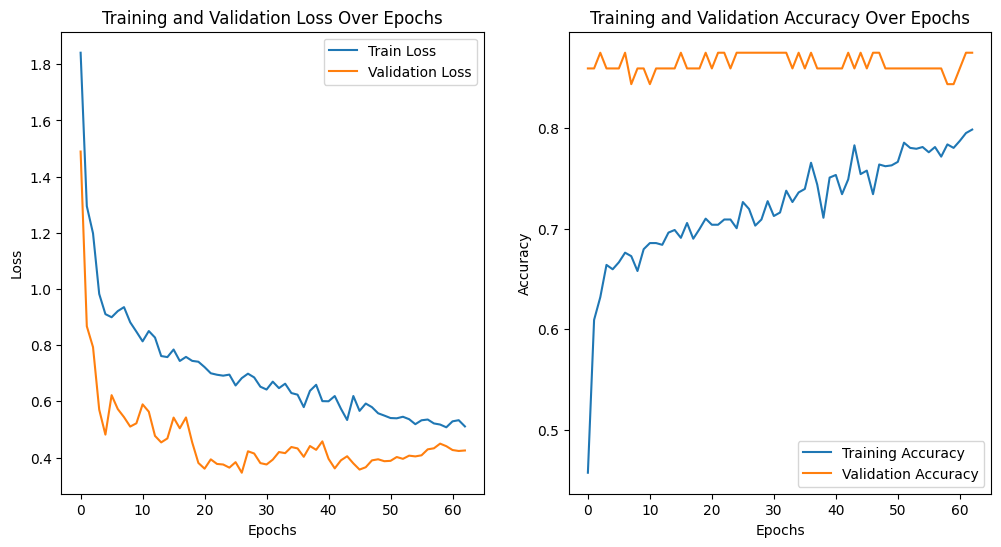

In [27]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(train_loss,label='Train Loss')
plt.plot(val_loss,label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(train_acc,label='Training Accuracy')
plt.plot(val_acc,label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

In [28]:
test_result = model.evaluate(test_dataset)
print(f'{model.metrics_names}: {test_result}')

5/5 [==============================] - 2s 339ms/step - loss: 0.3117 - accuracy: 0.8938
['loss', 'accuracy']: [0.31174787878990173, 0.893750011920929]


In [29]:
model_path = "resnet_callback/train_conv5_bestmodel_epoch63_nopool_valloss0.29.h5"
loaded_model = tf.keras.models.load_model(model_path)
results = loaded_model.evaluate(test_dataset)
print(f'{loaded_model.metrics_names}: {results}')

2023-11-11 16:17:05.295752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 5s 343ms/step - loss: 0.3094 - accuracy: 0.8938
['loss', 'accuracy']: [0.30936047434806824, 0.893750011920929]


In [30]:
model_path = "resnet_callback/train_conv5_bestmodel_epoch60_nopool_valloss0.27.h5"
loaded_model = tf.keras.models.load_model(model_path)
results = loaded_model.evaluate(test_dataset)
print(f'{loaded_model.metrics_names}: {results}')

2023-11-11 16:17:15.991323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 5s 345ms/step - loss: 0.3553 - accuracy: 0.8938
['loss', 'accuracy']: [0.3552975058555603, 0.893750011920929]


In [31]:
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

In [32]:
last_conv_layer_name = "conv5_block3_out"

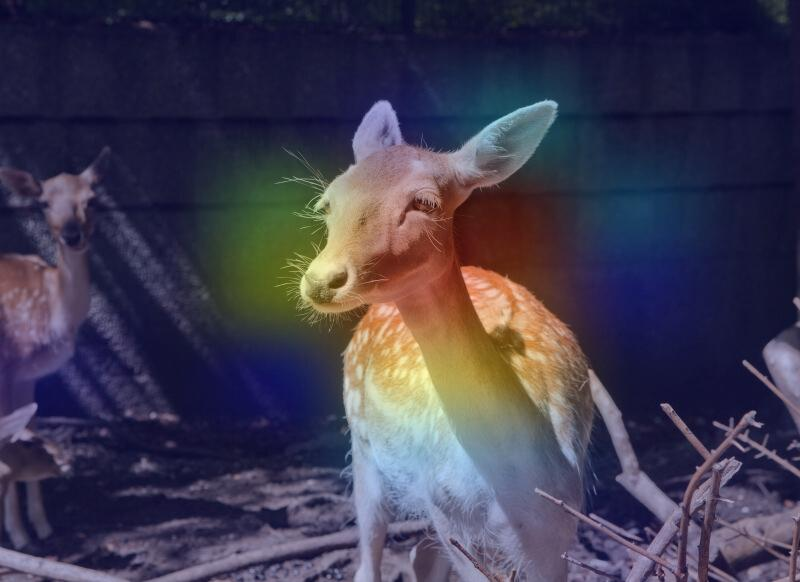

In [33]:
grad_cam_img_path = 'dataset/train/deer/fallow_deer_4.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(preprocess_input(img), model, last_conv_layer_name)
save_and_display_gradcam(grad_cam_img_path, heatmap)

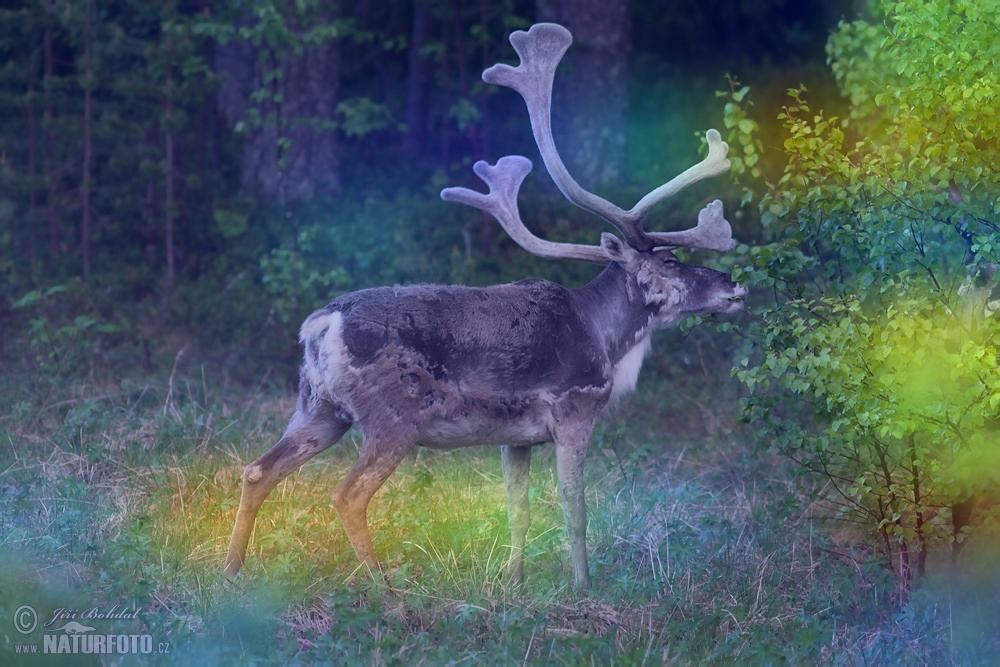

In [34]:
grad_cam_img_path = 'dataset/train/caribou/Male_Caribou56.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(preprocess_input(img), model, last_conv_layer_name)
save_and_display_gradcam(grad_cam_img_path, heatmap)

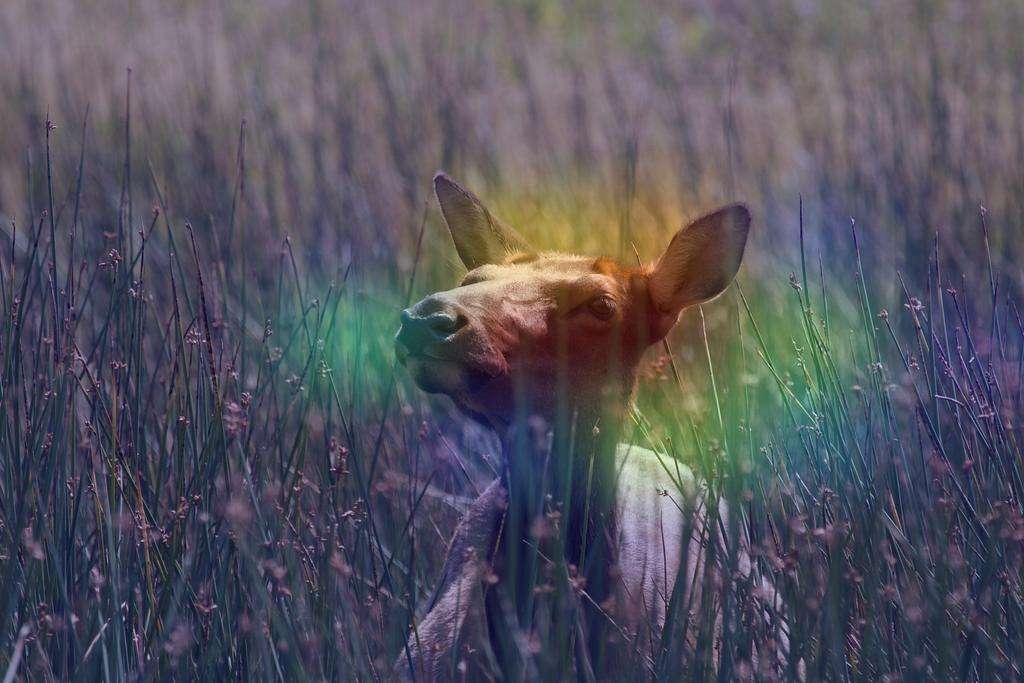

In [35]:
grad_cam_img_path = 'dataset/train/elk/EDF9.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(preprocess_input(img), model, last_conv_layer_name)

save_and_display_gradcam(grad_cam_img_path, heatmap)

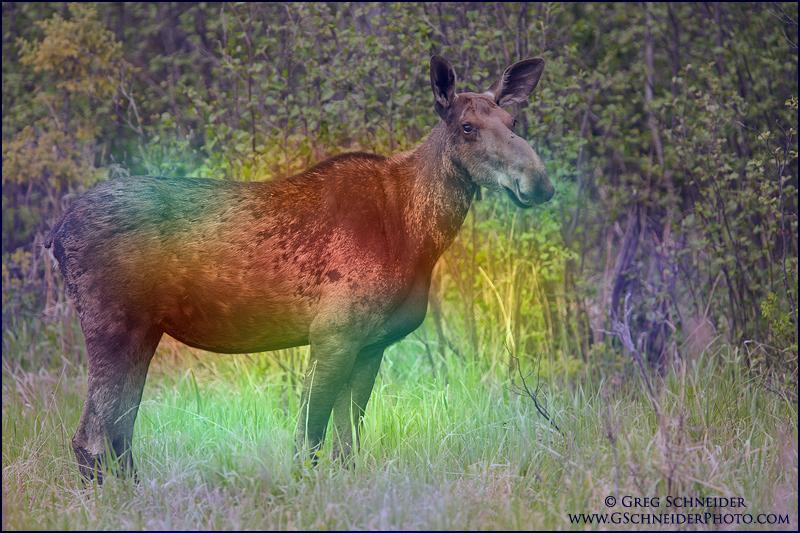

In [36]:

grad_cam_img_path = 'dataset/train/moose/female_moose (23).jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(preprocess_input(img), model, last_conv_layer_name)

save_and_display_gradcam(grad_cam_img_path, heatmap)

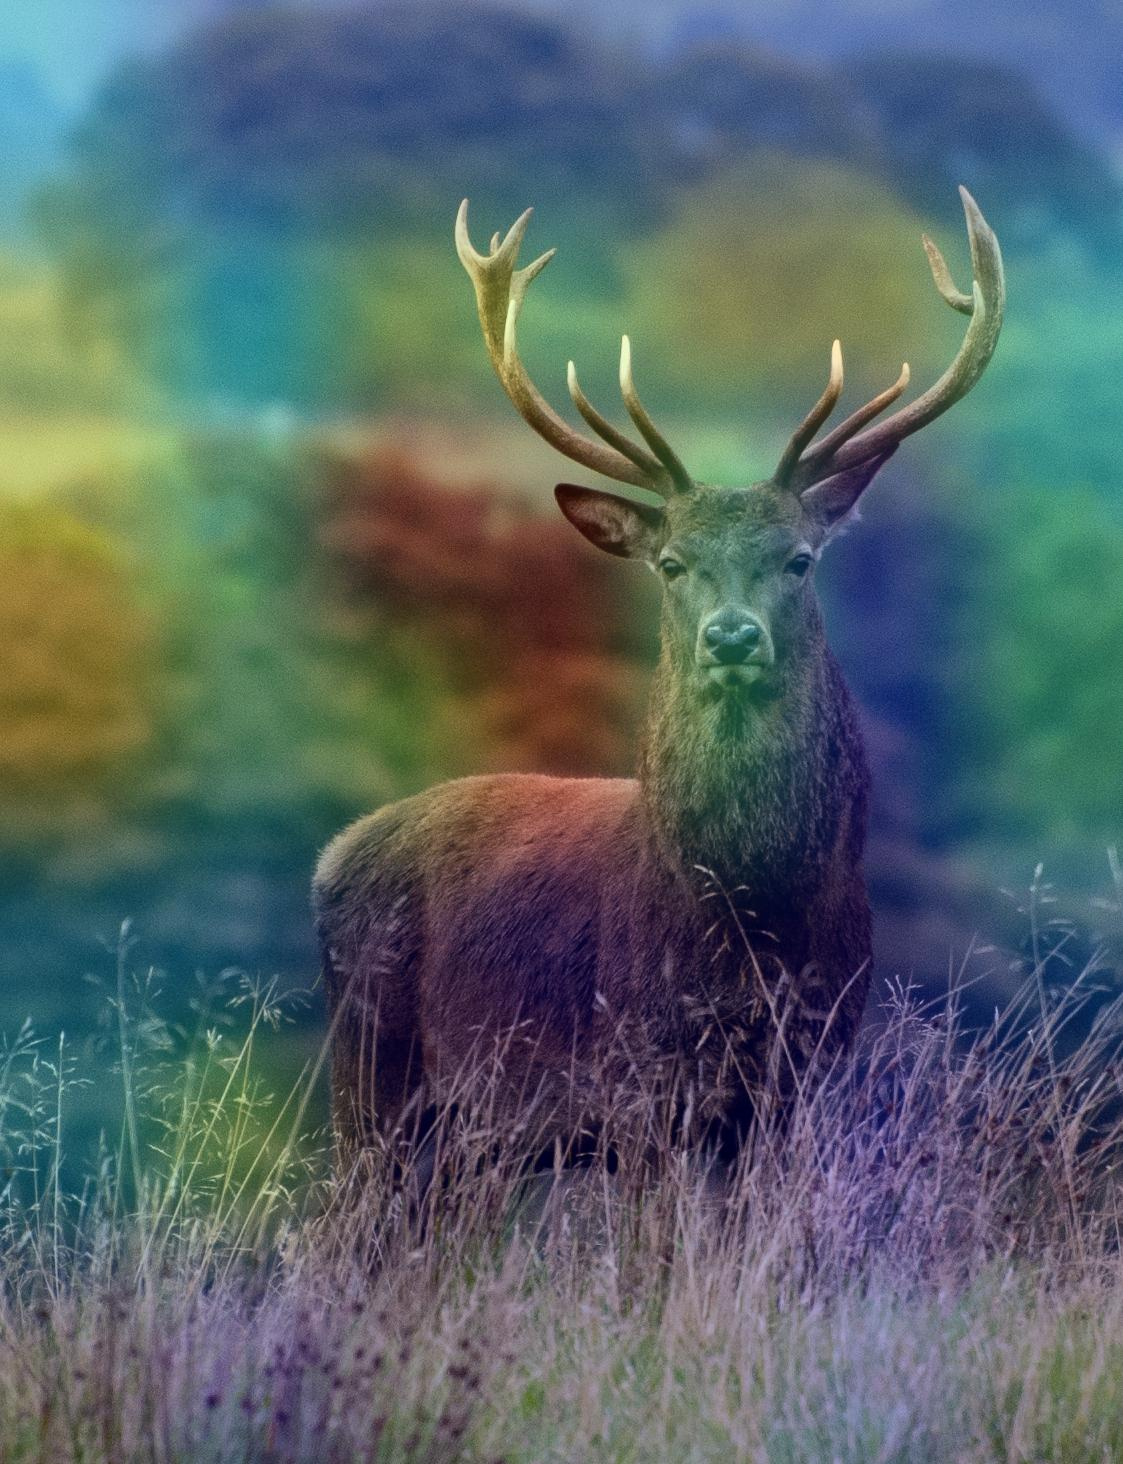

In [37]:
grad_cam_img_path = 'dataset/test/deer/red_deer_00044.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(preprocess_input(img), model, last_conv_layer_name)

save_and_display_gradcam(grad_cam_img_path, heatmap)

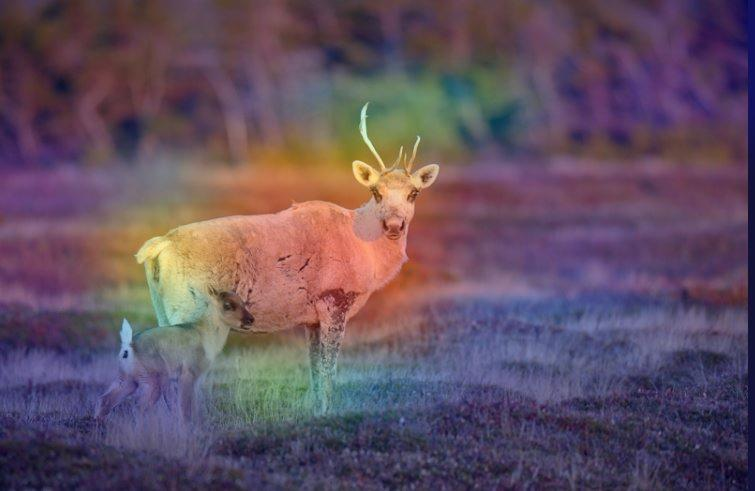

In [38]:
grad_cam_img_path = 'dataset/train/caribou/Female_Caribou91.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(preprocess_input(img), model, last_conv_layer_name)

save_and_display_gradcam(grad_cam_img_path, heatmap)

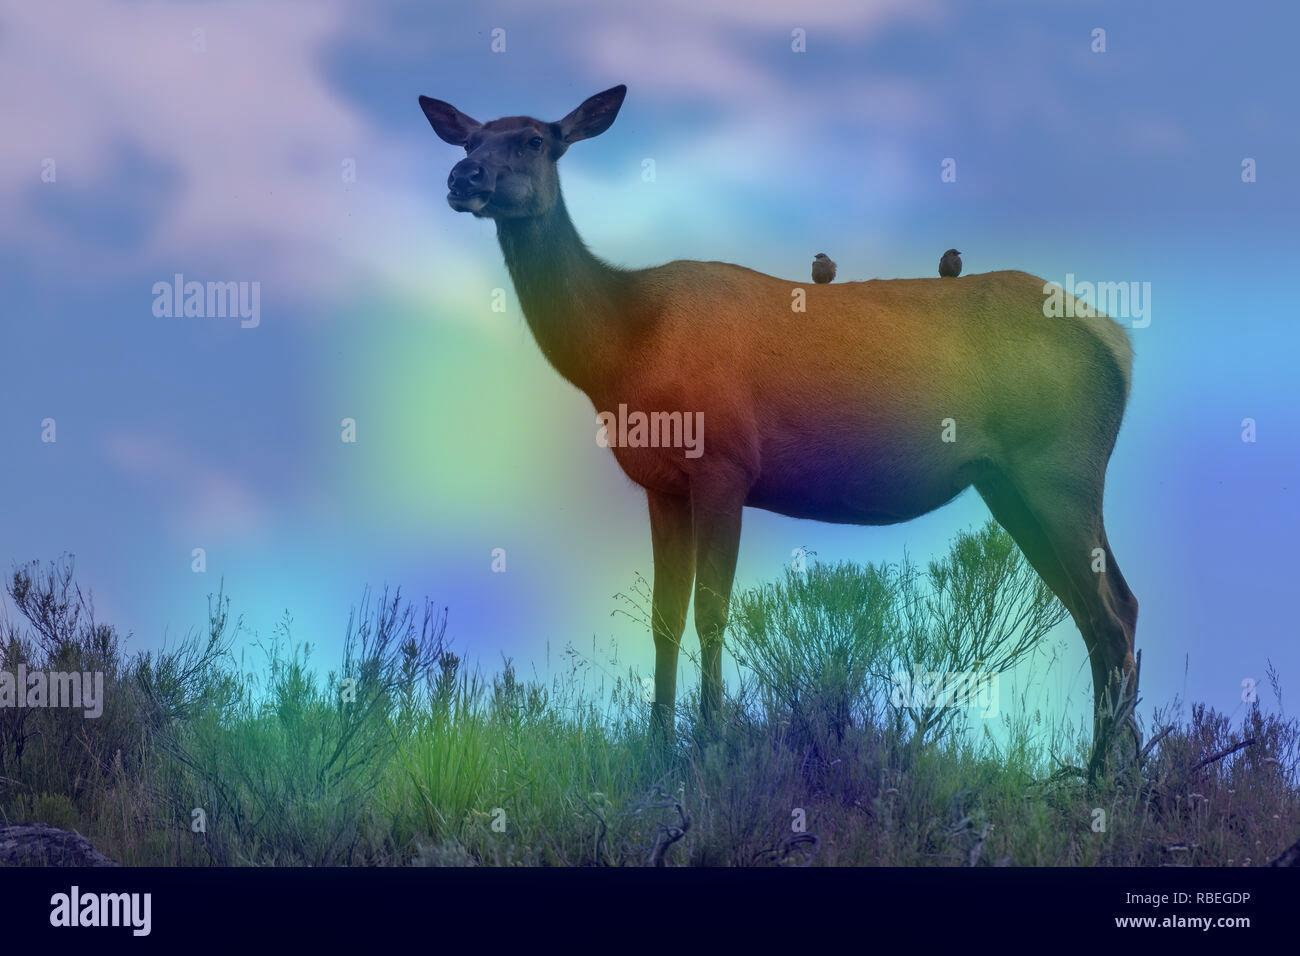

In [39]:
grad_cam_img_path = 'dataset/train/elk/EDF78.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(preprocess_input(img), model, last_conv_layer_name)

save_and_display_gradcam(grad_cam_img_path, heatmap)

2023-11-11 16:17:31.343783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 4s 4s/step


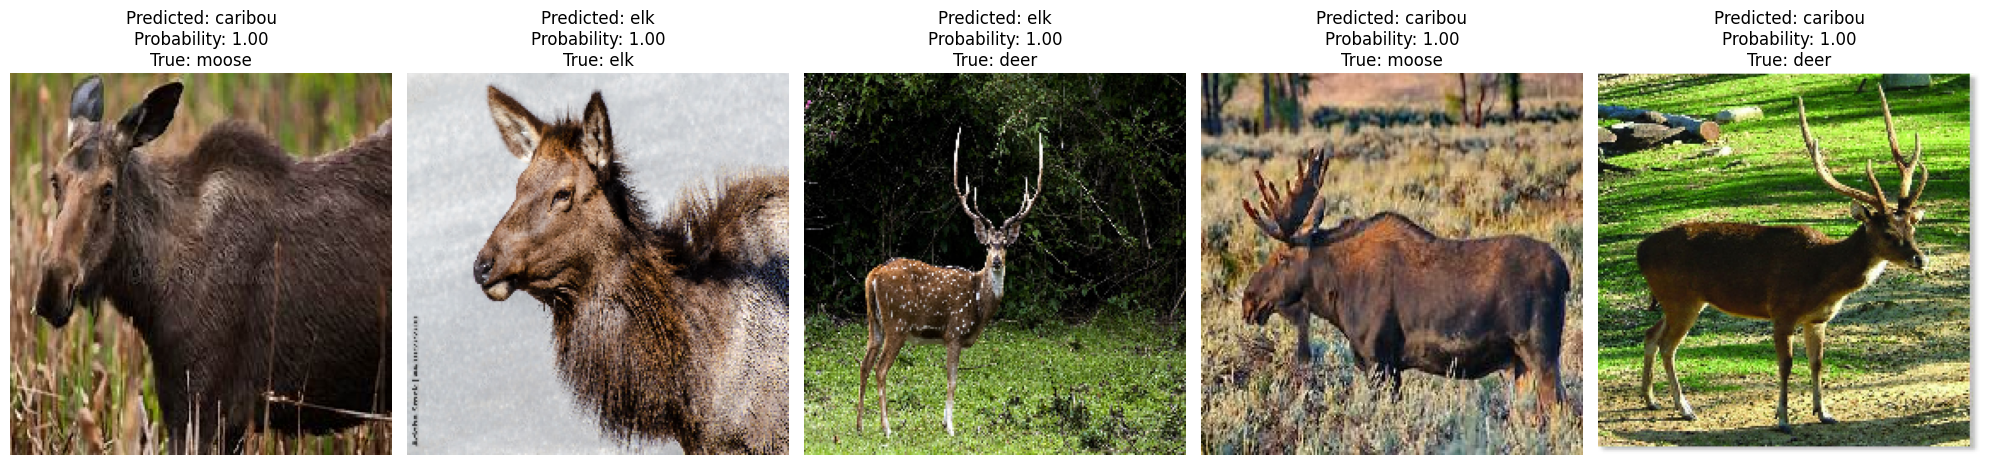

In [40]:
test_images_directory = 'dataset/test/'
class_name = {0:'caribou',1:'deer',2:'elk',3:'moose'}
show_predicted_img(model,test_images_directory,class_name)

In [41]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image, label in test_dataset:
   # append true labels
   y_true.append(label)
   # compute predictions
   preds = model.predict(image)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 146ms/step


Text(0.5, 1.0, 'ResNet152V2')

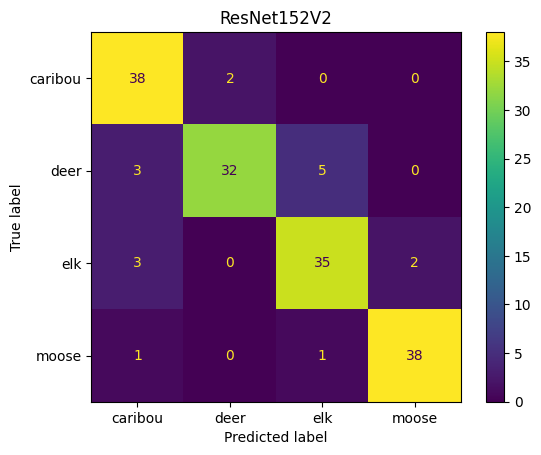

In [42]:
label = ["caribou","deer","elk","moose"]
ConfusionMatrixDisplay.from_predictions(correct_labels, predicted_labels,display_labels=label)
plt.title("ResNet152V2")

In [43]:
print(classification_report(correct_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89        40
           1       0.94      0.80      0.86        40
           2       0.85      0.88      0.86        40
           3       0.95      0.95      0.95        40

    accuracy                           0.89       160
   macro avg       0.90      0.89      0.89       160
weighted avg       0.90      0.89      0.89       160



1/1 [==============================] - 3s 3s/step


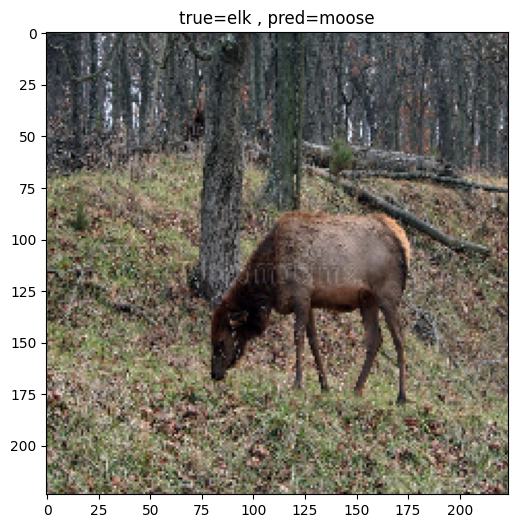

In [44]:
"""
dataset/test/caribou/Male_Caribou8.jpg
dataset/test/elk/EDF91.jpg
dataset/test/moose/male_moose (86).jpg
dataset/test/deer/white_tailed_deer_00019.jpg
"""
img_path = 'dataset/test/elk/EDF91.jpg'

label_dict = {0:"caribou",1:"deer",2:"elk",3:"moose"}
y_true = img_path.split("/")
img = tf.keras.utils.load_img(img_path, target_size=(224,224))
array = tf.keras.utils.img_to_array(img)
array = np.expand_dims(array, axis=0)
x = preprocess_input(array)
preds = model.predict(x)
y_pred = np.argmax(preds)
plt.figure( figsize=(12,6))
ax = plt.gca()
plt.imshow(img)
plt.title( f"true={y_true[2]} , pred={label_dict[y_pred]}" )
plt.show()

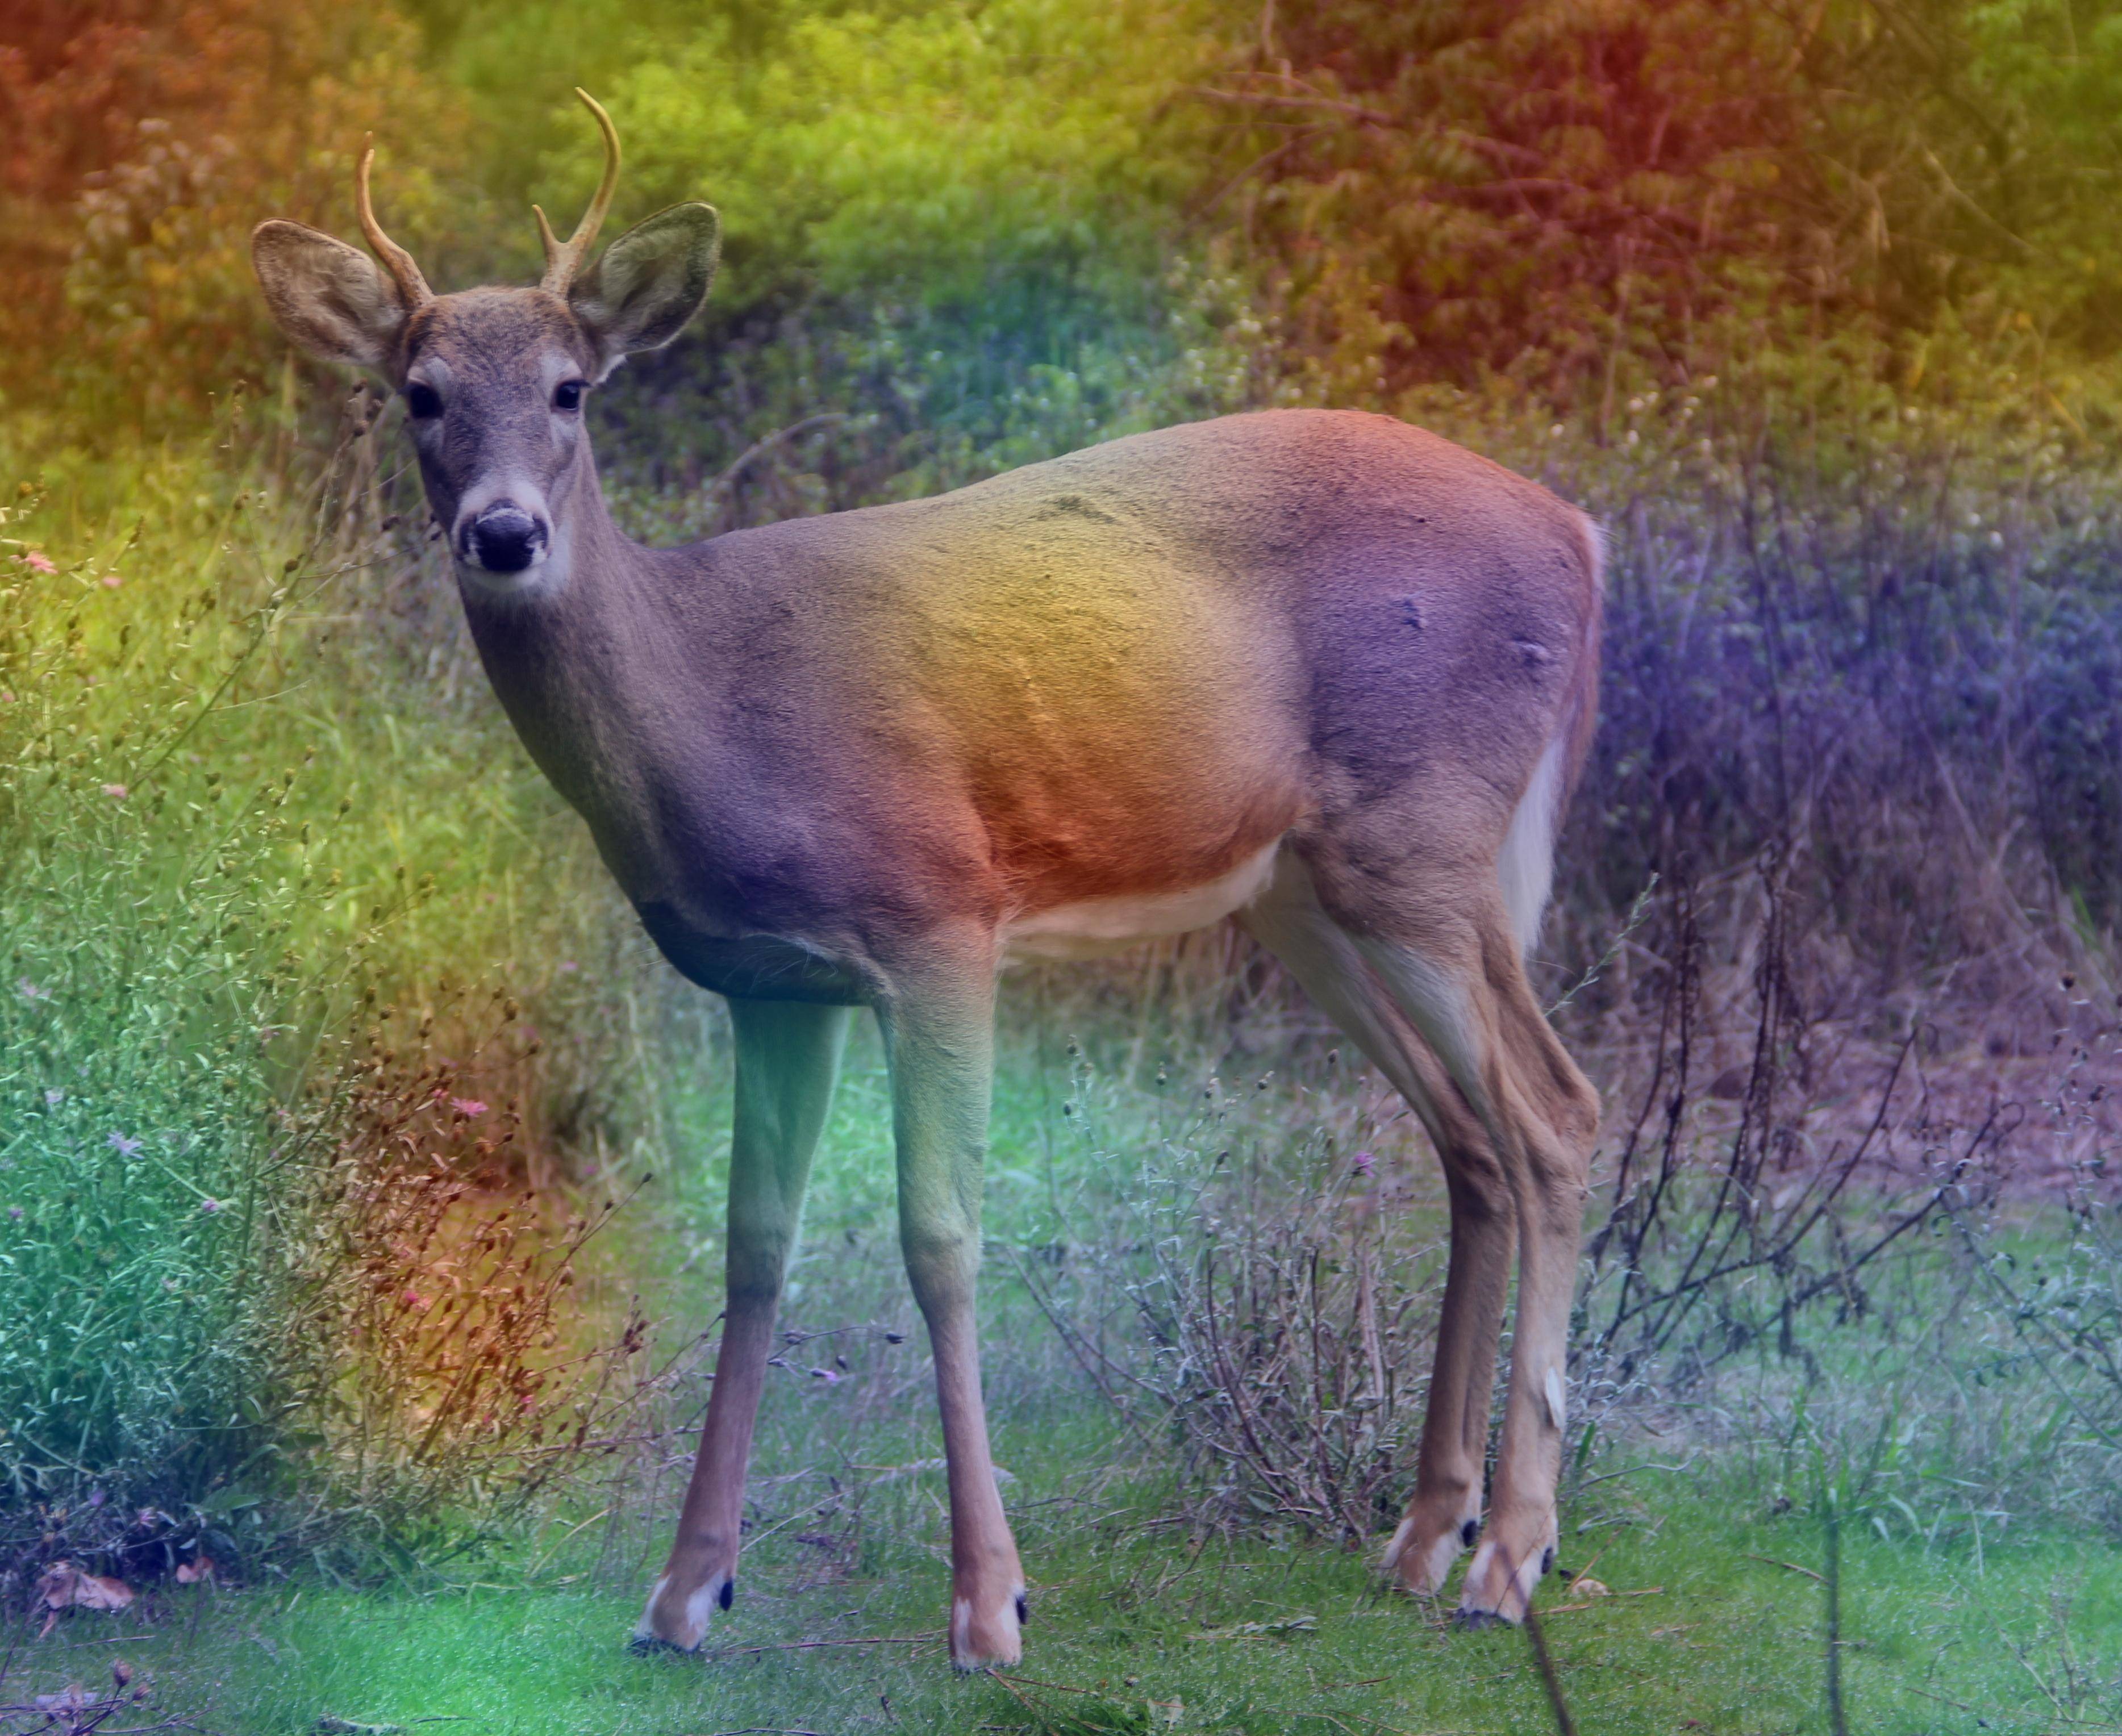

In [45]:
"""
dataset/test/caribou/Male_Caribou8.jpg
dataset/test/elk/EDF91.jpg
dataset/test/moose/male_moose (86).jpg
dataset/test/deer/white_tailed_deer_00019.jpg
"""
last_conv_layer_name = "conv5_block3_out"
grad_cam_img_path = 'dataset/test/deer/white_tailed_deer_00019.jpg'
img = get_img_array(grad_cam_img_path,size=(224,224))
heatmap = make_gradcam_heatmap(preprocess_input(img), model, last_conv_layer_name)

save_and_display_gradcam(grad_cam_img_path, heatmap)